# Introduction

In the class of machine learning approaches that are based on tree-like decision makers, many improved algorithms have been developed over the past two decades. We will go through three noteworthy designs that build on the idea of ensembles. The general idea is to train multiple models and combine them in various ways to improve performance.

There are two primary ways of doing this when it comes to decision trees. The first is to average the output of multiple trees which limits the variance of the output given the central limit theorem. The second way is to build trees in sequence and use the output of each one to reduce the bias in the next one.

# Bagging Regressor
A Bagging model works by dividing a dataset, training one tree per subset, and averaging the results. There are variants of the Bagging approach with distinct names determined by how the data is divided (i.e. Pasting, Bagging, Random Subspaces, Random Patches, etc...).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_covtype

In [2]:
# covtype is a moderately complex "real world" dataset
# it might take a minute to download the dataset

covtype = fetch_covtype()

x, xt, y, yt = train_test_split(covtype.data, covtype.target, test_size = 0.20)

print(covtype.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

    =================   ============
    Classes                        7
    Samples total             581012
    Dimensionality                54
    Features                     int
    =================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional a

In [3]:
# now that datasets are bigger, training takes marginally longer
# we will intentionally restrict depth to make differences more apparent

m = DecisionTreeClassifier(max_depth=15)

m.fit(x, y)

ŷ = m.predict(xt)
accuracy_score(yt, ŷ)

0.8550725884873884

In [4]:
confusion_matrix(yt, ŷ)

array([[35050,  7195,     0,     0,    35,    10,   233],
       [ 4544, 51276,   240,     0,    73,   279,    29],
       [    5,   445,  6094,    38,     5,   654,     0],
       [    0,     2,    90,   402,     0,    54,     0],
       [   39,  1154,    25,     0,   688,     2,     0],
       [    4,   677,   445,    11,     3,  2285,     0],
       [  489,    61,     0,     0,     0,     0,  3567]], dtype=int64)

Text(0.5, 1.0, 'Mean AUC 0.85')

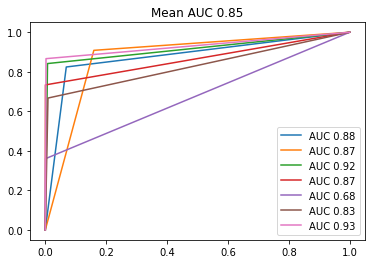

In [5]:
# compute ROC curves for each class and plot them

plt.close('all')

ytb = label_binarize(yt, classes=np.union1d(y, yt))
ŷb = label_binarize(ŷ, classes=np.union1d(y, yt))

fig, ax = plt.subplots()
area = []
for i in range(len(np.union1d(y, yt))):
    fpr, tpr, _ = roc_curve(ytb[:,i], ŷb[:,i])
    a = auc(fpr, tpr)
    area.append(a)
    plt.plot(fpr, tpr, label='AUC %0.2f' % a)

plt.legend(loc="lower right")
plt.title("Mean AUC %0.2f" % np.mean(area))

In [6]:
# we are training the same tree but using bagging
# set the number of estimators to the number of CPUs on your computer

mb = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15),
                       n_estimators=32,
                       verbose=1,
                       n_jobs=-1)

mb.fit(x, y)

ŷ = mb.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:   16.9s remaining:  4.2min
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:   30.9s finished
[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    0.3s remaining:    5.7s
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    1.1s finished


0.8866552498644613

Text(0.5, 1.0, 'Mean AUC 0.88')

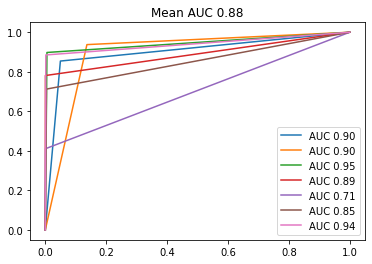

In [7]:
# compute ROC curves for each class and plot them

plt.close('all')

ytb = label_binarize(yt, classes=np.union1d(y, yt))
ŷb = label_binarize(ŷ, classes=np.union1d(y, yt))

fig, ax = plt.subplots()
area = []
for i in range(len(np.union1d(y, yt))):
    fpr, tpr, _ = roc_curve(ytb[:,i], ŷb[:,i])
    a = auc(fpr, tpr)
    area.append(a)
    plt.plot(fpr, tpr, label='AUC %0.2f' % a)

plt.legend(loc="lower right")
plt.title("Mean AUC %0.2f" % np.mean(area))

# Random Forest
In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

In contrast to the original publication [B2001], the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=None (always considering all features instead of a random subset) for regression problems, and max_features="sqrt" (using a random subset of size sqrt(n_features)) for classification tasks (where n_features is the number of features in the data). Good results are often achieved when setting max_depth=None in combination with min_samples_split=2 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

Finally, this module also features the parallel construction of the trees and the parallel computation of the predictions through the n_jobs parameter. If n_jobs=k then computations are partitioned into k jobs, and run on k cores of the machine. If n_jobs=-1 then all cores available on the machine are used. Note that because of inter-process communication overhead, the speedup might not be linear (i.e., using k jobs will unfortunately not be k times as fast). Significant speedup can still be achieved though when building a large number of trees, or when building a single tree requires a fair amount of time (e.g., on large datasets).

In [8]:
# we need to set the maximum number of features explicitly 
# for a 1:1 comparison with DecisionTreeClassifier

mrf = RandomForestClassifier(max_depth=15, max_features=54, n_estimators=32, verbose=1, n_jobs=-1)

mrf.fit(x, y)

ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  32 | elapsed:   10.6s remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   21.6s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    0.0s remaining:    0.9s
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    0.1s finished


0.8845985043415402

In [9]:
# A forest does not overfit as easily as a single tree so we can increase depth

mrf = RandomForestClassifier(max_features=54, n_estimators=32, verbose=1, n_jobs=-1)

mrf.fit(x, y)

ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  32 | elapsed:   14.7s remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   20.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   2 out of  32 | elapsed:    0.0s remaining:    1.0s
[Parallel(n_jobs=32)]: Done  32 out of  32 | elapsed:    0.1s finished


0.9669888040756263

In [10]:
# Other parameter changes provide only marginal gains
# Doubling the number of trees makes a negligible difference

mrf = RandomForestClassifier(max_features=54, n_estimators=64, verbose=1, n_jobs=-1)

mrf.fit(x, y)

ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   38.3s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  64 out of  64 | elapsed:    0.2s finished


0.9675911981618375

# Gradient Tree Boosting

In [12]:
import xgboost as xgb

C:\Users\rluci\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [13]:
# XGBoost wants the data serialized into a data structure called Dmatrix
xd = xgb.DMatrix(data=x, label=y)

In [15]:
# since we're building a classifier we use the logistic loss function

params = {'objective':'reg:logistic',
          'colsample_bytree':'0.3',
          'learning_rate':'0.1',
          'max_depth':'15',
          'alpha':'10',
          'n_estimators':'32'}
mxgb = xgb.XGBClassifier(objective='reg:logistic',
                         colsample_bytree=0.3,
                         learning_rate=0.1,
                         max_depth=15,
                         alpha=10,
                         n_estimators=32,
                         )

mxgb.fit(x, y)
ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

C:\Users\rluci\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:40:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  64 out of  64 | elapsed:    0.1s finished


0.9675911981618375